In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
path = 'AB_Testing_Data.csv'

In [3]:
ab_test_df = pd.read_csv(path)

In [4]:
ab_test_df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [5]:
ab_test_df = ab_test_df.rename(columns = lambda column_name: column_name.lower())

In [6]:
ab_test_df.shape

(10000, 3)

In [7]:
ab_test_df.dtypes

user_id           int64
variant_name     object
revenue         float64
dtype: object

In [8]:
ab_test_df.nunique()

user_id         6324
variant_name       2
revenue          101
dtype: int64

In [9]:
ab_test_df.isna().sum()

user_id         0
variant_name    0
revenue         0
dtype: int64

In [21]:
ab_test_df[ab_test_df.duplicated ()]

,user_id,variant_name,revenue
106,7704,control,0.0
195,8406,variant,0.0
224,7042,variant,0.0
302,4409,control,0.0
422,1621,variant,0.0
...,...,...,...
9989,2444,variant,0.0
9993,2400,variant,0.0
9994,3129,control,0.0
9995,1981,control,0.0


In [23]:
ab_test_df['variant_name'].value_counts(normalize=True)

variant_name
variant    0.5016
control    0.4984
Name: proportion, dtype: float64

In [26]:
ab_test_df.groupby('user_id')['variant_name'].nunique().value_counts(normalize=True)

variant_name
1    0.756325
2    0.243675
Name: proportion, dtype: float64

In [32]:
ab_df_unique = ab_test_df.drop_duplicates()

In [33]:
len(ab_df_unique)

7933

In [42]:
ab_df_unique.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [38]:
ab_df_unique['variant_name'].value_counts(normalize=True)

variant_name
control    0.500819
variant    0.499181
Name: proportion, dtype: float64

<Axes: >

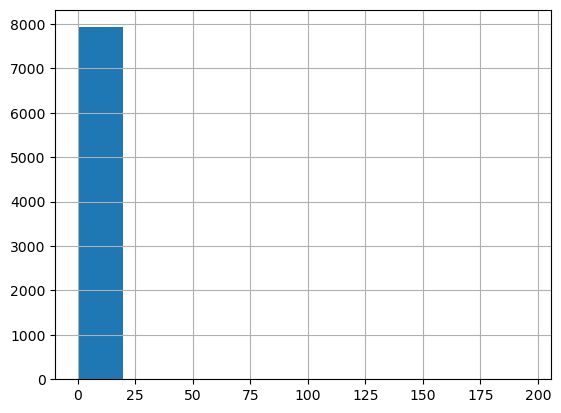

In [40]:
ab_df_unique['revenue'].hist()

In [41]:
ab_df_unique['revenue'].describe()

count    7933.000000
mean        0.125359
std         2.602527
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: revenue, dtype: float64

In [74]:
control =ab_df_unique.query("variant_name =='control'").reset_index(drop= True  )

In [75]:
test =ab_df_unique.query("variant_name =='variant'").reset_index(drop= True )

In [77]:
control.head()

,user_id,variant_name,revenue
0,2423,control,0.0
1,9411,control,0.0
2,7311,control,0.0
3,2849,control,0.0
4,9168,control,0.0


(0.0, 10.0)

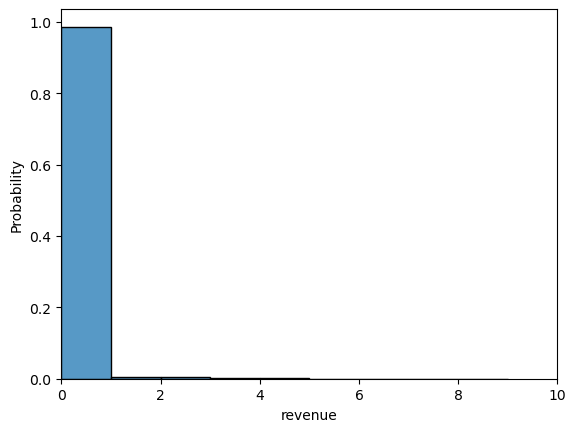

In [80]:
fig = plt.figure()
ax_clicks = fig.add_subplot()
clicks_distr = sns.histplot(control['revenue'],  # Теперь это массив длины experiments * N
                            bins=range(0, 10),
                            kde=False,
                            ax=ax_clicks,
                            stat='probability')
ax_clicks.set_xlim((0, 10))

(0.0, 10.0)

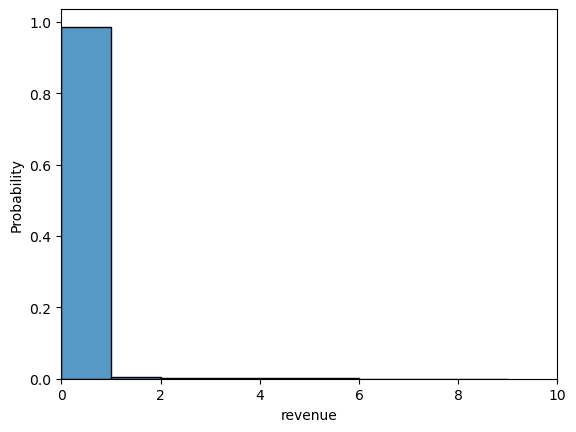

In [81]:
fig = plt.figure()
ax_clicks = fig.add_subplot()
clicks_distr = sns.histplot(test['revenue'],  # Теперь это массив длины experiments * N
                            bins=range(0, 10),
                            kde=False,
                            ax=ax_clicks,
                            stat='probability')
ax_clicks.set_xlim((0, 10))